In [7]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp,odeint

In [36]:
# 1.1 solution
# cart pole dynamc system
M=1 # mass of the car in kg
m=0.1 # mass of the pendulum in kg
g=9.81 # gravity
l=0.8 # length of the inverted pendulum in m

def ode_fun(x,t,u):

    p,theta,v,omega=x
    
    dp=v
    dtheta=omega
    dv=((-m*l*np.sin(theta)*omega**2)+(m*g*np.cos(theta)*np.sin(theta))+u)/(M+m-m*(np.cos(theta))**2)
    domega=((-m*l*np.cos(theta)*np.sin(theta)*omega**2)+(u*np.cos(theta))+((M+m)*g*np.sin(theta)))/(l*(M+m-m*(np.cos(theta)**2)))

    return [dp,dtheta,dv,domega]



In [54]:

# Define the Runge-Kutta 4th order integration function to get the next step
def rk4_step( x, u, dt):
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def rk5_step(x, u, dt):
    k1 = dt * dynamics(x, u)
    k2 = dt * dynamics(x + (k1 / 4), u)
    k3 = dt * dynamics(x + (k1 * 3.0 / 32.0) + (k2 * 9.0 / 32.0), u)
    k4 = dt * dynamics(x + (k1 * 1932.0 / 2197.0) - (k2 * 7200.0 / 2197.0) + (k3 * 7296.0 / 2197.0), u)
    k5 = dt * dynamics(x + (k1 * 439.0 / 216.0) - (k2 * 8.0) + (k3 * 3680.0 / 513.0) - (k4 * 845.0 / 4104.0), u)
    
    return x + ((25.0 * k1 / 216.0) + (1408.0 * k3 / 2565.0) + (2197.0 * k4 / 4104.0 )- (k5 / 5.0))


    
def rk4_integrator(ode_func,x0,Ts,nSteps,u):


    t = [0]
    x = [x0]

    for i in range(nSteps):
        tn = t[-1]
        xn = x[-1]

        xn1 = rk4_step(xn,u,Ts)
        tn1 = tn + Ts

        t.append(tn1)
        x.append(xn1)

    return np.array(t), np.array(x)
    

time_manual [ 0.    0.05  0.1  ... 49.9  49.95 50.  ]
time_lib [ 0.    0.05  0.1  ... 49.9  49.95 50.  ]


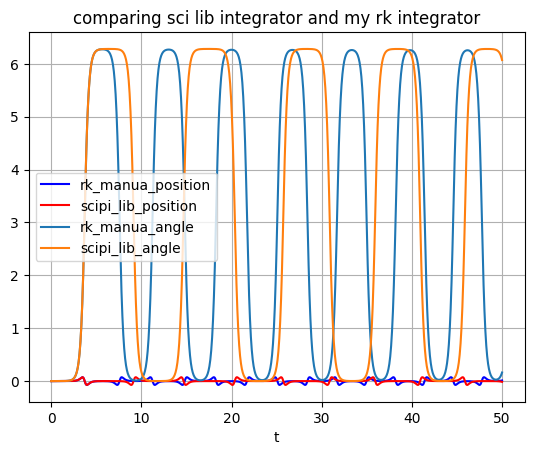

In [55]:
#1.2 solution
# converting ODE to discrete time for x(k+1)= fd(x(k),u(k))
Ts=0.05
nSteps=1000
u=0
x0=[0,0+0.00001,0,0]
t_span=np.linspace(0,Ts*nSteps,nSteps+1)

# Solve the ODE using odeint
sol_lib_fun = odeint(ode_fun, x0, t_span, args=(u,))

# solution using manual rk oder 4
time_manual, x_manual=rk4_integrator(ode_fun,x0,Ts,nSteps,u)

# Extract the solution
t = t_span

print("time_manual",time_manual)
print("time_lib",t_span)


# Print or use the output as needed
plt.plot(time_manual, x_manual[:,0], 'b', label='rk_manua_position')
plt.plot(t, sol_lib_fun[:, 0], 'r', label='scipi_lib_position')

plt.plot(time_manual, x_manual[:,1], label='rk_manua_angle')
plt.plot(t, sol_lib_fun[:, 1], label='scipi_lib_angle')
plt.title("comparing sci lib integrator and my rk integrator")

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()


In [154]:
# soluton for question 1.3 

import autograd.numpy as np
from autograd import jacobian


# Constants
m = 1.0
l = 1.0
M = 1.0
g = 9.81

# Define the function ode_fun(x, u)
def dynamics(x, u):
    # p=x1 
    # theta=x2
    # v=x3
    # omega =x4

    p,theta,v,omega=x
    
    dp = v
    dtheta = omega
    dv = ((-m*l*np.sin(theta)*omega**2) + (m*g*np.cos(theta)*np.sin(theta)) + u) / (M+m-m*(np.cos(theta))**2)
    domega = ((-m*l*np.cos(theta)*np.sin(theta)*omega**2) + (u*np.cos(theta)) + ((M+m)*g*np.sin(theta))) / (l*(M+m-m*(np.cos(theta)**2)))

    return np.array([dp, dtheta, dv, domega])


# Define the Runge-Kutta 4th order integration function to get the next step
def rk4_step( x, u, dt):
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6.0) * (k1 + 2*k2 + 2*k3 + k4)

u0=0.0
dt=0.05
x0 = np.array([0.0, 0.0, 0.0, 0.0])

Ad=jacobian(rk4_step,argnum=0)(x0,u0,dt)
Bd=jacobian(rk4_step,argnum=1)(x0,u0,dt)


In [192]:
def ihlqr(A, B, Q, R, max_iter=1000, tol=1e-5):
    # Get the size of x and u from B
    nx = B.shape

    # Initialize P with Q
    P = np.copy(Q)

    # Ricatti
    for ricatti_iter in range(1, max_iter+1):
        K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)
        P_new = Q + K.T @ R @ K + (A - B @ K).T @ P @ (A - B @ K)

        if np.linalg.norm(P - P_new, ord=1) < tol:
            return P_new, K
        else:
            P = np.copy(P_new)

    raise ValueError("ihlqr did not converge")

In [193]:
# question 1.4 to 1.5 designing a non linear state feedback regulator for the system

xgoal=np.array([1.0,0.0,0.0,0.0])
ugoal=0.0

state_dim=4;
control_dim=1

x0=np.array([0,np.pi/10,0,0])
#simulation size
dt=0.1
tf=10.0
nSteps=int(tf/dt)
t_span=np.linspace(0,dt*nSteps,nSteps)

X=[np.zeros(state_dim) for i in range(nSteps)] # array to to store and plot the state values
X[0]=x0

#cost function
Q=np.diag([1,1,0.05,1])
Qf=Q
R=np.array([[0]])

# state and control matrix
Ad=jacobian(rk4_step,argnum=0)(xgoal,ugoal,dt)
Bd=jacobian(rk4_step,argnum=1)(xgoal,ugoal,dt)
Bd=np.reshape(Bd,(4,1))

# calculate the P and K matrices of infinite horizon LQR using ilqr function
P,K= ihlqr(Ad,Bd,Q,R)



for i in range(nSteps-1):
    dx=(xgoal-X[i])
    u_lqr= K @ dx
    X[i+1]=rk4_step(X[i],u_lqr[0],dt)

position_trajectory=[array[0] for array in X]
angle_trajectory=[array[1] for array in X]

    
ref_angle_trajectory=np.full_like(position_trajectory, xgoal[1])
ref_pos_trajectory=np.full_like(position_trajectory, xgoal[0])

    
    
    






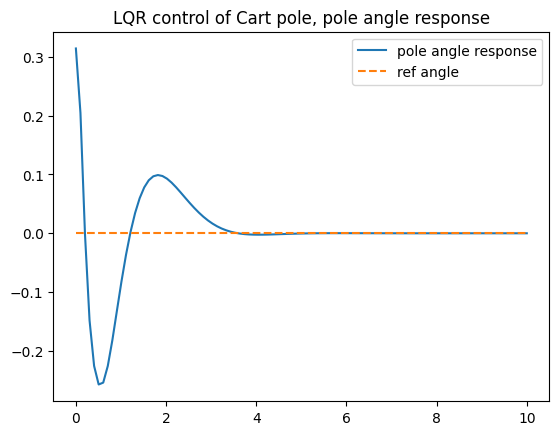

In [194]:
import matplotlib.pyplot as plt
plt.plot(t_span,angle_trajectory,label="pole angle response")
plt.plot(t_span,ref_angle_trajectory,'--',label="ref angle")
plt.title("LQR control of Cart pole, pole angle response")
plt.legend()
plt.savefig("LQR pole angle response.png")
plt.show()

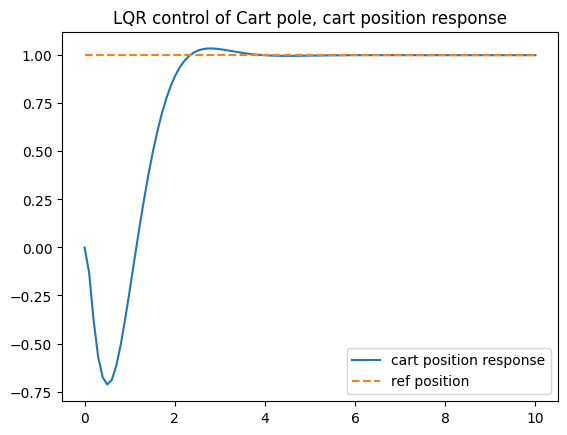

In [195]:
plt.plot(t_span,position_trajectory,label="cart position response")
plt.plot(t_span,ref_pos_trajectory,'--',label="ref position")
plt.title("LQR control of Cart pole, cart position response")
plt.legend()
plt.savefig("LQR cart position response.png")
plt.show()